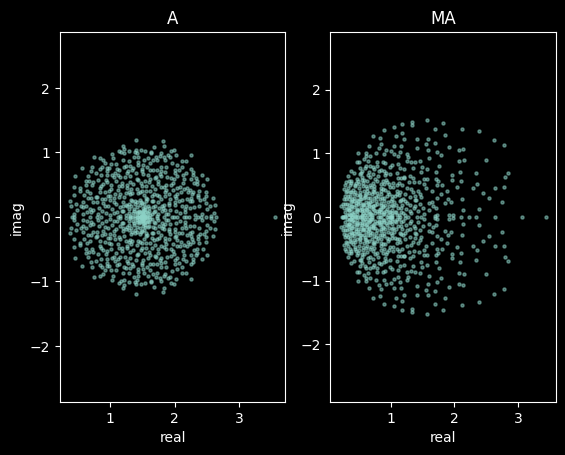

In [36]:
#8.8.2
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

A = 1.5 * sp.sparse.eye(800) + sp.sparse.random(800, 800, density=0.005, format='csc')
tau = 0.3
iLU = sp.sparse.linalg.spilu(A, drop_tol=tau)
A_dense = A.toarray()
L_dense = iLU.L.toarray()
U_dense = iLU.U.toarray()
M = L_dense @ U_dense

MA = sp.linalg.solve(M, A_dense)
ev_A = np.linalg.eigvals(A_dense)
ev_MA = np.linalg.eigvals(MA)

plt.subplot(1, 2, 1)
plt.scatter(np.real(ev_A), np.imag(ev_A), s=5, alpha=0.5)
plt.title('A'), plt.xlabel('real'), plt.ylabel('imag')
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.scatter(np.real(ev_MA), np.imag(ev_MA), s=5, alpha=0.5)
plt.title('MA'), plt.xlabel('real'), plt.ylabel('imag')
plt.axis('equal')
plt.show()




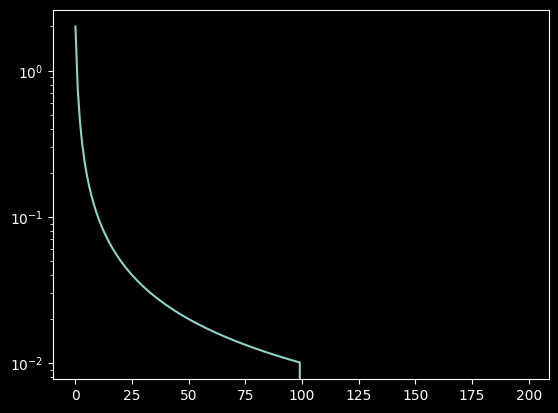

In [65]:
#8.8.3(a)
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

B = sp.sparse.diags([np.arange(1, 101)], [0] , format='csc')
B_dense = B.toarray()
I = np.eye(100)
Z = np.zeros((100, 100))
b = np.ones(200)

A = sp.sparse.bmat([
    [B, I],
    [Z, -B]
], format='csc')

diag_values = np.concatenate([np.ones(100), -np.ones(100)])
M = sp.sparse.diags(diag_values, 0, format='csc')

redis = []
hist = lambda x: redis.append(x)
x, _ = sp.sparse.linalg.gmres(A, b, M=M, rtol=1e-10, maxiter=100, callback=hist)

plt.semilogy(redis)

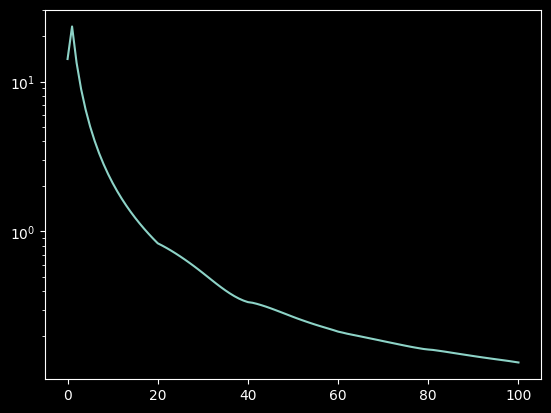

In [68]:
    #8.8.3(b)
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

B = sp.sparse.diags([np.arange(1, 101)], [0] , format='csc')
B_dense = B.toarray()
I = np.eye(100)
Z = np.zeros((100, 100))
b = np.ones(200)

A = sp.sparse.bmat([
    [B, I],
    [Z, -B]
], format='csc')

diag_values = np.concatenate([
    np.arange(1, 101),      # 对应上半部分 B (1 到 100)
    -np.arange(1, 101)      # 对应下半部分 -B (-1 到 -100)
])
M = sp.sparse.diags(diag_values, 0, format='csc')

redis = []
redis.append(np.linalg.norm(b))
hist = lambda res: redis.append(res)
x, _ = sp.sparse.linalg.gmres(A, b, M=M, rtol=1e-10, maxiter=100, callback=hist)

plt.semilogy(redis)

In [82]:
#8.8.4(a)
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

A = sp.io.mmread("FNC Chapter 8/rdb2048.mtx").tocsr()
b = np.ones(2048)

redis = [np.linalg.norm(b)]
hist = lambda res: redis.append(res)
start_time = time.perf_counter()
x, flag = sp.sparse.linalg.gmres(A, b, rtol=1e-4, maxiter=300, callback=hist)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"GMRES 求解耗时: {elapsed_time:.6f} 秒")
if flag == 0:
    print("收敛成功")
else:
    print("收敛失败")


GMRES 求解耗时: 0.023318 秒
收敛成功


In [92]:
#8.8.4(b)
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

A = sp.io.mmread("FNC Chapter 8/rdb2048.mtx").tocsr()
b = np.ones(2048)

redis = [np.linalg.norm(b)]
hist = lambda res: redis.append(res)
prec = sp.sparse.diags(1 / A.diagonal(), 0)
start_time = time.perf_counter()

x, flag = sp.sparse.linalg.gmres(A, b, M=prec, rtol=1e-4, maxiter=300, callback=hist)
end_time = time.perf_counter()

elapsed_time = end_time - start_time

print(f"GMRES 求解耗时: {elapsed_time:.6f} 秒")
if flag == 0:
    print("收敛成功")
else:
    print("收敛失败")


GMRES 求解耗时: 0.029457 秒
收敛失败


In [122]:
#8.8.4(c)
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

A = sp.io.mmread("FNC Chapter 8/rdb2048.mtx").tocsr()
b = np.ones(2048)

tau = 0.02
try:
    iLU = sp.sparse.linalg.spilu(A.tocsc() ,drop_tol=tau)
    prec = sp.sparse.linalg.LinearOperator(A.shape, matvec=lambda y:iLU.solve(y))
    redis = [np.linalg.norm(b)]
    hist = lambda res: redis.append(res)

    start_time = time.perf_counter()

    x, flag = sp.sparse.linalg.gmres(A, b, M=prec, restart=300, rtol=1e-4, maxiter=300, callback=hist)
    end_time = time.perf_counter()

    elapsed_time = end_time - start_time

    print(f"GMRES 求解耗时: {elapsed_time:.6f} 秒")
    if flag == 0:
        print("收敛成功")
    else:
        print("收敛失败")
except RuntimeError as e:
    print(e)


GMRES 求解耗时: 0.061036 秒
收敛成功


In [118]:
import numpy as np
import scipy as sp
import scipy.sparse.linalg
import scipy.io
import time

# 1. 确保数据加载正确
try:
    A = sp.io.mmread("FNC Chapter 8/rdb2048.mtx").tocsr()
    b = np.ones(A.shape[0])
except:
    print("找不到文件，请检查路径")

# 2. 定义我们要测试的 tau 列表（从粗糙到精细）
# 我们涵盖几个数量级，看看哪个能活下来
candidates = [0.1, 0.05, 0.02, 0.01, 0.008, 0.005, 0.002, 0.001, 1e-4, 1e-5]

print(f"{'Tau':<10} | {'Status':<15} | {'Time (s)':<10} | {'Result'}")
print("-" * 50)

for tau in candidates:
    try:
        # 尝试构建 ILU
        start_t = time.perf_counter()

        # 关键：加上 fill_factor 稍微给点容错空间
        iLU = sp.sparse.linalg.spilu(A.tocsc(), drop_tol=tau, fill_factor=20)

        M_op = sp.sparse.linalg.LinearOperator(A.shape, matvec=lambda x: iLU.solve(x))

        # 尝试求解
        x, flag = sp.sparse.linalg.gmres(A, b, M=M_op, restart=None, rtol=1e-4, maxiter=300)

        end_t = time.perf_counter()
        elapsed = end_t - start_t

        if flag == 0:
            print(f"{tau:<10} | {'✅ Converged':<15} | {elapsed:<10.4f} | Success")
        else:
            print(f"{tau:<10} | {'⚠️ No Conv':<15} | {elapsed:<10.4f} | MaxIter reached")

    except RuntimeError as e:
        # 这里捕获 singular 错误
        print(f"{tau:<10} | {'❌ Singular':<15} | {'---':<10} | Crashed")
    except Exception as e:
        print(f"{tau:<10} | {'❌ Error':<15} | {'---':<10} | {str(e)}")

Tau        | Status          | Time (s)   | Result
--------------------------------------------------
0.1        | ⚠️ No Conv      | 1.3319     | MaxIter reached
0.05       | ⚠️ No Conv      | 1.3110     | MaxIter reached
0.02       | ✅ Converged     | 0.0217     | Success
0.01       | ✅ Converged     | 0.0097     | Success
0.008      | ✅ Converged     | 0.0084     | Success
0.005      | ✅ Converged     | 0.0075     | Success
0.002      | ✅ Converged     | 0.0075     | Success
0.001      | ✅ Converged     | 0.0070     | Success
0.0001     | ✅ Converged     | 0.0068     | Success
1e-05      | ✅ Converged     | 0.0064     | Success
